# Parameter Estimation with DELFI-C3
## Objectives
This example will guide you through the set-up of an orbit estimation routine, which usually comprises the estimation of the covariance, as well as the estimation of the initial parameters. In this example we will focus on the latter, and you'll learn: 
 
* how to set up and perform the **full estimation** of a spacecraft's initial state, drag coefficient, and radiation pressure coefficient
 
For the **covariance analysis** over the course of the spacecraft's orbit see the [Delfi-C3 Covariance Analysis example](covariance_estimated_parameters.ipynb).
 
If you have already followed the covariance example, you might want to **skip the first part of this example** dealing with the setup of all relevant (environment, propagation, and estimation) modules, and dive straight in to the full estimation of all chosen parameters.
 
To simulate the orbit of a spacecraft, we will fall back and reiterate on all aspects of orbit propagation that are important within the scope of orbit estimation. Further, we will highlight all relevant features of modelling a tracking station on Earth. Using this station, we will simulate a tracking routine of the spacecraft using a series of open-loop Doppler range-rate measurements at 1 mm/s every 60 seconds. To assure an uninterrupted line-of-sight between the station and the spacecraft, a minimum elevation angle of more than 15 degrees above the horizon - as seen from the station - will be imposed as constraint on the simulation of observations.

## Import statements
Typically - in the most pythonic way - all required modules are imported at the very beginning.

Some standard modules are first loaded: `numpy` and `matplotlib.pyplot`.

Then, the different modules of `tudatpy` that will be used are imported. Most notably, the `estimation`, `estimation_setup`, and `observations` modules will be used and demonstrated within this example.

In [65]:
# Load required standard modules
import numpy as np
from matplotlib import pyplot as plt

In [66]:
# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion

## Configuration
First, NAIF's `SPICE` kernels are loaded, to make the positions of various bodies such as the Earth, the Sun, or the Moon known to `tudatpy`.
 
Subsequently, the start and end epoch of the simulation are defined. Note that using `tudatpy`, the times are generally specified in seconds since J2000. Hence, setting the start epoch to `0` corresponds to the 1st of January 2000. The end epoch specifies a total duration of the simulation of three days.
 
For more information on J2000 and the conversion between different temporal reference frames, please refer to the [API documentation](https://py.api.tudat.space/en/latest/time_conversion.html) of the `time_conversion` module.

NOTE: 
To avoid issues with the interpolator, we define a time buffer and add we subtract it and add it to the simulation start and end epoch, respectively. 

In [67]:
# Load spice kernels
spice.load_standard_kernels()

In [68]:
# Set simulation start and end epochs
time_buffer = 10
simulation_start_epoch = DateTime(2000, 1, 1).epoch() - time_buffer
simulation_end_epoch   = DateTime(2000, 1, 4).epoch() + time_buffer

## Set up the environment
We will now create and define the settings for the environment of our simulation. In particular, this covers the creation of (celestial) bodies, vehicle(s), and environment interfaces.
 
### Create the main bodies
To create the systems of bodies for the simulation, one first has to define a list of strings of all bodies that are to be included. Note that the default body settings (such as atmosphere, body shape, rotation model) are taken from the `SPICE` kernel.
 
These settings, however, can be adjusted. Please refer to the [Available Environment Models](https://docs.tudat.space/en/latest/_src_user_guide/state_propagation/environment_setup/environment_models.html#available-model-types) in the user guide for more details.
 
Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [69]:
# Create default body settings for "Sun", "Earth", "Moon", "Mars", and "Venus"
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

In [70]:
# Create default body settings for bodies_to_create, with "Earth"/"J2000" as the global frame origin and orientation
global_frame_origin = "Earth"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

### Create the vehicle and its environment interface
We will now create the satellite - called Delfi-C3 - for which an orbit will be simulated. Using an `empty_body` as a blank canvas for the satellite, we define mass of 2.2 kg, a reference area (used both for aerodynamic and radiation pressure) of 4m$^2$, and a aerodynamic drag coefficient of 1.2. Idem for the radiation pressure coefficient. Finally, when setting up the radiation pressure interface, the Earth is set as a body that can occult the radiation emitted by the Sun.

In [71]:
# Create empty body settings for the satellite
body_settings.add_empty_settings("Delfi-C3")

In [72]:
body_settings.get("Delfi-C3").constant_mass = 2.2

In [73]:
# Create aerodynamic coefficient interface settings
reference_area_drag = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area_drag, [drag_coefficient, 0.0, 0.0]
)

In [74]:
# Add the aerodynamic interface to the body settings
body_settings.get("Delfi-C3").aerodynamic_coefficient_settings = aero_coefficient_settings

In [75]:
# Create radiation pressure settings
reference_area_radiation = (4*0.3*0.1+2*0.1*0.1)/4  # Average projection area of a 3U CubeSat
radiation_pressure_coefficient = 1.2
occulting_bodies_dict = dict()
occulting_bodies_dict["Sun"] = ["Earth"]
vehicle_target_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area_radiation, radiation_pressure_coefficient, occulting_bodies_dict )

In [76]:
# Add the radiation pressure interface to the body settings
body_settings.get("Delfi-C3").radiation_pressure_target_settings = vehicle_target_settings

Finally, the system of bodies is created using the settings. This system of bodies is stored into the variable `bodies`.

In [77]:
# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

## Set up the propagation
Having the environment created, we will define the settings for the propagation of the spacecraft. First, we have to define the body to be propagated - here, the spacecraft - and the central body - here, Earth - with respect to which the state of the propagated body is defined.

In [78]:
# Define bodies that are propagated
bodies_to_propagate = ["Delfi-C3"]

In [79]:
# Define central bodies of propagation
central_bodies = ["Earth"]

### Create the acceleration model
Subsequently, all accelerations (and there settings) that act on `Delfi-C3` have to be defined. In particular, we will consider:

* Gravitational acceleration using a spherical harmonic approximation up to 8th degree and order for Earth.
* Aerodynamic acceleration for Earth.
* Gravitational acceleration using a simple point mass model for:

  - The Sun
  - The Moon
  - Mars

* Radiation pressure experienced by the spacecraft - shape-wise approximated as a spherical cannonball - due to the Sun.

The defined acceleration settings are then applied to `Delfi-C3` by means of a dictionary, which is finally used as input to the propagation setup to create the acceleration models.

In [80]:
# Define the accelerations acting on Delfi-C3
accelerations_settings_delfi_c3 = dict(
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Moon=[
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 8),
        propagation_setup.acceleration.aerodynamic()
    ])

In [81]:
# Create global accelerations dictionary
acceleration_settings = {"Delfi-C3": accelerations_settings_delfi_c3}

In [82]:
# Create acceleration models
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies)

### Define the initial state
Realise that the initial state of the spacecraft always has to be provided as a cartesian state - i.e. in the form of a list with the first three elements representing the initial position, and the three remaining elements representing the initial velocity.

Within this example, we will retrieve the initial state of Delfi-C3 using its Two-Line-Elements (TLE) the date of its launch (April the 28th, 2008). The TLE strings are obtained from [space-track.org](https://www.space-track.org).

In [83]:
# Retrieve the initial state of Delfi-C3 using Two-Line-Elements (TLEs)
delfi_tle = environment.Tle(
    "1 32789U 07021G   08119.60740078 -.00000054  00000-0  00000+0 0  9999",
    "2 32789 098.0082 179.6267 0015321 307.2977 051.0656 14.81417433    68",
)
delfi_ephemeris = environment.TleEphemeris("Earth", "J2000", delfi_tle, False)
initial_state = delfi_ephemeris.cartesian_state( simulation_start_epoch )

### Create the integrator settings
For the problem at hand, we will use an RKF78 integrator with a fixed step-size of 60 seconds. This can be achieved by tweaking the implemented RKF78 integrator with variable step-size such that both the minimum and maximum step-size is equal to 60 seconds and a tolerance of 1.0

In [84]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.\
    runge_kutta_fixed_step_size(initial_time_step=60.0,
                                coefficient_set=propagation_setup.integrator.CoefficientSets.rkdp_87)

### Create the propagator settings
By combining all of the above-defined settings we can define the settings for the propagator to simulate the orbit of `Delfi-C3` around Earth. A termination condition needs to be defined so that the propagation stops as soon as the specified end epoch is reached. Finally, the translational propagator's settings are created.

In [85]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

In [86]:
# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    simulation_start_epoch,
    integrator_settings,
    termination_condition
)

## Set up the observations
Having set the underlying dynamical model of the simulated orbit, we can define the observational model. Generally, this entails the addition all required ground stations, the definition of the observation links and types, as well as the precise simulation settings.

### Add a ground station
Trivially, the simulation of observations requires the extension of the current environment by at least one observer - a ground station. For this example, we will model a single ground station located in Delft, Netherlands, at an altitude of 0m, 52.00667°N, 4.35556°E.

More information on how to use the `add_ground_station()` function can be found in the respective [API documentation](https://py.api.tudat.space/en/latest/environment_setup.html#tudatpy.numerical_simulation.environment_setup.add_ground_station).

In [87]:
# Define the position of the ground station on Earth
station_altitude = 0.0
delft_latitude = np.deg2rad(52.00667)
delft_longitude = np.deg2rad(4.35556)

In [88]:
# Add the ground station to the environment
environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "TrackingStation",
    [station_altitude, delft_latitude, delft_longitude],
    element_conversion.geodetic_position_type)

### Define Observation Links and Types
To establish the links between our ground station and `Delfi-C3`, we will make use of the [observation module](https://py.api.tudat.space/en/latest/observation.html#observation) of tudat. During the link definition, each member is assigned a certain function within the link, for instance as "transmitter", "receiver", or "reflector". Once two (or more) members are connected to a link, they can be used to simulate observations along this particular link. The precise type of observation made along this link - e.g., range, range-rate, angular position, etc. - is then determined by the chosen observable type.

To fully define an observation model for a given link, we have to create a list of the observation model settings of all desired observable types and their associated links. This list will later be used as input to the actual estimator object.

Each observable type has its own function for creating observation model settings - in this example we will use the `one_way_doppler_instantaneous()` function to model a series of one-way open-loop (i.e. instantaneous) Doppler observations. Realise that the individual observation model settings can also include corrective models or define biases for more advanced use-cases.

In [89]:
# Define the uplink link ends for one-way observable
link_ends = dict()
link_ends[observation.receiver] = observation.body_reference_point_link_end_id("Earth", "TrackingStation")
link_ends[observation.transmitter] = observation.body_origin_link_end_id("Delfi-C3")

In [90]:
# Create observation settings for each link/observable
link_definition = observation.LinkDefinition(link_ends)
observation_settings_list = [observation.one_way_doppler_instantaneous(link_definition)]

### Define Observation Simulation Settings
We now have to define the times at which observations are to be simulated. To this end, we will define the settings for the simulation of the individual observations from the previously defined observation models. Bear in mind that these observation simulation settings are not to be confused with the ones to be used when setting up the estimator object, as done just above.

Finally, for each observation model, the observation simulation settings set the times at which observations are simulated and defines the viability criteria and noise of the observation.

Note that the actual simulation of the observations requires `Observation Simulators`, which are created automatically by the `Estimator` object. Hence, one cannot simulate observations before the creation of an estimator.

Also, we recall we had applied a time buffer to our start and end epoch, so it is now the time to remove it.

In [91]:
# Define observation simulation times for each link (separated by steps of 1 minute)
observation_times = np.arange(simulation_start_epoch + time_buffer, simulation_end_epoch - time_buffer, 60.0)
observation_simulation_settings = observation.tabulated_simulation_settings(
    observation.one_way_instantaneous_doppler_type,
    link_definition,
    observation_times
)

In [92]:
# Add noise levels of roughly 3.3E-12 [s/m] and add this as Gaussian noise to the observation
noise_level = 1.0E-3
observation.add_gaussian_noise_to_observable(
    [observation_simulation_settings],
    noise_level,
    observation.one_way_instantaneous_doppler_type
)

In [93]:
# Create viability settings
viability_setting = observation.elevation_angle_viability(["Earth", "TrackingStation"], np.deg2rad(15))
observation.add_viability_check_to_all(
    [observation_simulation_settings],
    [viability_setting]
)

## Set up the estimation
Using the defined models for the environment, the propagator, and the observations, we can finally set the actual presentation up. In particular, this consists of defining all parameter that should be estimated, the creation of the estimator, and the simulation of the observations.

### Defining the parameters to estimate
For this example estimation, we decided to estimate the initial state of `Delfi-C3`, its drag coefficient, and the gravitational parameter of Earth.

In [94]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(propagator_settings, bodies)

In [95]:
# Add estimated parameters to the sensitivity matrix that will be propagated
parameter_settings.append(estimation_setup.parameter.gravitational_parameter("Earth"))
parameter_settings.append(estimation_setup.parameter.constant_drag_coefficient("Delfi-C3"))

In [96]:
# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(parameter_settings, bodies)

### Creating the Estimator object
Ultimately, the `Estimator` object consolidates all relevant information required for the estimation of any system parameter:

* the environment (bodies)
* the parameter set (parameters_to_estimate)
* observation models (observation_settings_list)
* dynamical, numerical, and integrator setup (propagator_settings)

Underneath its hood, upon creation, the estimator automatically takes care of setting up the relevant Observation Simulator and Variational Equations which will subsequently be required for the simulation of observations and the estimation of parameters, respectively.

In [97]:
# Create the estimator
estimator = numerical_simulation.Estimator(
    bodies,
    parameters_to_estimate,
    observation_settings_list,
    propagator_settings)

### Perform the observations simulation
Using the created `Estimator` object, we can perform the simulation of observations by calling its `simulate_observations()` method, see the [API reference](https://py.api.tudat.space/en/latest/estimation.html#tudatpy.numerical_simulation.estimation.simulate_observations). Note that to know about the time settings for the individual types of observations, this function makes use of the earlier defined observation simulation settings.

In [98]:
# Simulate required observations
simulated_observations = estimation.simulate_observations(
    [observation_simulation_settings],
    estimator.observation_simulators,
    bodies)

## Perform the estimation
Having simulated the observations and created the `Estimator` object - containing the **variational equations** for the parameters to estimate - we have defined everything to conduct the actual estimation. Realise that up to this point, we have not yet specified whether we want to perform a **covariance analysis** or the **full estimation** of all parameters. It should be stressed that the general setup for either path to be followed is entirely **identical**.

### Set up the inversion
To set up the inversion of the problem, we collect all relevant inputs in the form of a estimation input object and define some basic settings of the inversion. Most crucially, this is the step where we can account for different **weights** - if any - of the different observations in the `ObservationCollection`, to give the estimator knowledge about the quality of the individual types of observations.

In [99]:
simulated_observations.set_constant_weight(noise_level ** -2)

In [100]:
# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector

In [101]:
# Perturb the initial state estimate from the truth (10 m in position; 0.1 m/s in velocity)
perturbed_parameters = truth_parameters.copy( )
for i in range(3):
    perturbed_parameters[i] += 10.0
    perturbed_parameters[i+3] += 0.01

In [102]:
perturbed_parameters[6] += 1e5
perturbed_parameters[7] += 0.01

In [103]:
parameters_to_estimate.parameter_vector = perturbed_parameters

In [104]:
# Create input object for the estimation
convergence_checker = estimation.estimation_convergence_checker(maximum_iterations=4)
estimation_input = estimation.EstimationInput(
    simulated_observations,
    convergence_checker=convergence_checker)

In [105]:
# Set methodological options
estimation_input.define_estimation_settings(
    reintegrate_variational_equations=False)

### Estimate the individual parameters
Using the just defined inputs, we can ultimately run the estimation of the selected parameters. After a pre-defined maximum number of iterations (the default value is set to a total of five), the least squares estimator - ideally having reached a sufficient level of convergence - will stop with the process of iterating over the problem and updating the parameters.

In [106]:
# Perform the estimation
estimation_output = estimator.perform_estimation(estimation_input)

Calculating residuals and partials 59
Current residual: 14.0604
Parameter update    -26.1432     -13.5053     -16.3786 -0.000146171   -0.0198624   -0.0248741  1.88058e+09  -0.00843802
Calculating residuals and partials 59
Current residual: 0.0279887
Parameter update     15.7994      3.37537      6.61705   -0.0101473   0.00969867    0.0146291 -1.90341e+09  -0.00153908
Calculating residuals and partials 59
Current residual: 0.00110458
Parameter update 8.96218e-05 -6.44971e-05  3.93707e-06  1.34155e-07  -2.1837e-07 -1.34838e-08     -6417.87 -1.93475e-07
Calculating residuals and partials 59
Current residual: 0.00109337
Maximum number of iterations reached
Parameter update 1.50479e-06  7.76897e-07 -1.27765e-06  8.00337e-10  3.55945e-11  1.84531e-09      38.8493 -4.64783e-09
Final residual: 0.00109337


## True Errors, Formal Errors

Since we have now estimated the actual parameters - unlike when only getting the initial covariance matrix over the course of the orbit, as done in [Delfi-C3 Covariance Analysis example](covariance_estimated_parameters.ipynb) - we are able to qualitatively compare the goodness-of-fit of the found parameters with the known ground truth ones. 

The common way to perform this comparison is by following these 3 simple steps:

1) Compute the formal errors. These are the **diagonal entries of the covariance matrix (variances)**
2) Take the difference between the true parameters (known) and the estimated ones (estimated)
3) Take the ratio between the results obtained in 2) and 1). This is the true-to-formal-error ratio.

Doing this might help highlight that the formal errors one gets as the result of a covariance analysis tend to sketch a too optimistic version of reality - typically, (all or some of) the true errors are by a certain factor larger than the formal ones. In this example, we see that the 3rd, 5th and 8th parameters estimates might be too optimistic, as their true-to-formal ratio is bigger than one. 

In [107]:
# Perturb the initial state estimate from the truth (10 m in position; 0.1 m/s in velocity)
# Save the true parameters to later analyse the error
truth_parameters = parameters_to_estimate.parameter_vector
perturbed_parameters = truth_parameters.copy( )
for i in range(3):
    perturbed_parameters[i] += 10.0
    perturbed_parameters[i+3] += 0.01

In [108]:
perturbed_parameters[6] += 1e5
perturbed_parameters[7] += 0.01

In [109]:
parameters_to_estimate.parameter_vector = perturbed_parameters

In [110]:
# Create input object for the estimation
convergence_checker = estimation.estimation_convergence_checker(maximum_iterations=4)
estimation_input = estimation.EstimationInput(
    simulated_observations,
    convergence_checker=convergence_checker)

In [111]:
# Set methodological options
estimation_input.define_estimation_settings(
    reintegrate_variational_equations=False)

In [112]:
# Print the formal errors (diagonal entries of the covariance matrix) and the true-to-formal-errors.
# Perform the estimation
estimation_output = estimator.perform_estimation(estimation_input)
formal_errors = estimation_output.formal_errors #formal errors
print(f'Formal Errors:\n\n{formal_errors}\n')

Calculating residuals and partials 59
Formal Errors:

[2.01309428e-01 1.57844190e-01 1.07627784e-01 1.24859058e-04
 1.66318974e-04 1.55529452e-04 1.24090045e+07 1.09842285e-04]

Current residual: 14.0603
Parameter update   -25.7997    -13.3755    -16.6167 0.000146897  -0.0196985  -0.0246293 1.90328e+09 -0.00846098
Calculating residuals and partials 59
Current residual: 0.0279885
Parameter update     15.7996      3.37561      6.61666    -0.010147   0.00969875    0.0146293 -1.90337e+09  -0.00153882
Calculating residuals and partials 59
Current residual: 0.00110458
Parameter update 8.91881e-05 -6.45257e-05  3.62851e-06  1.34269e-07 -2.18493e-07 -1.39994e-08     -6357.31 -1.97363e-07
Calculating residuals and partials 59
Current residual: 0.00109337
Maximum number of iterations reached
Parameter update-6.41814e-07 -5.76395e-07  1.07842e-06 -8.21259e-10  -5.2144e-11 -9.88119e-10     -82.9754  -8.5471e-10
Final residual: 0.00109337


In [113]:
true_errors = truth_parameters - parameters_to_estimate.parameter_vector #true_parameters - estimated_parameters = true error
print(f'True Errors:\n\n{true_errors}\n') 

True Errors:

[ 1.72993168e-06  1.00143370e-06 -1.16974115e-06  1.08047971e-09
  1.09139364e-11  2.27873898e-09  2.36250000e+01  5.89554028e-09]



In [114]:
true_to_formal_ratio = true_errors/formal_errors #true-to-formal-error ratio
print(f'True-To-Formal-Error Ratio:\n\n{true_to_formal_ratio}\n') 

True-To-Formal-Error Ratio:

[ 8.59339625e-06  6.34444449e-06 -1.08683939e-05  8.65359488e-06
  6.56205132e-08  1.46514949e-05  1.90385941e-06  5.36727752e-05]



## Post-Processing Results
Perfect, we have got our results. Now it is time to make sense of them. To further process them, one can - exemplary - plot:

1) the **behaviour of the simulated observations over time**;
2) the **history of the residuals**;
3) the **statistical interpretation of the final residuals**.

### Range-rate over time
First, we will thus plot all simulations we have simulated over time. One can clearly see how the satellite slowly emerges from the horizon and then more 'quickly' passes the station, until the visibility criterion is not fulfilled anymore.

In [115]:
observation_times = np.array(simulated_observations.concatenated_times)
observations_list = np.array(simulated_observations.concatenated_observations)

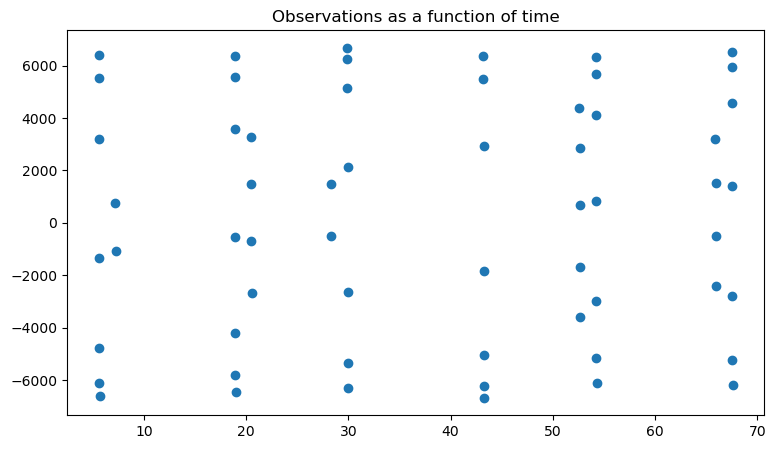

In [116]:
plt.figure(figsize=(9, 5))
plt.title("Observations as a function of time")
plt.scatter(observation_times / 3600.0, observations_list)

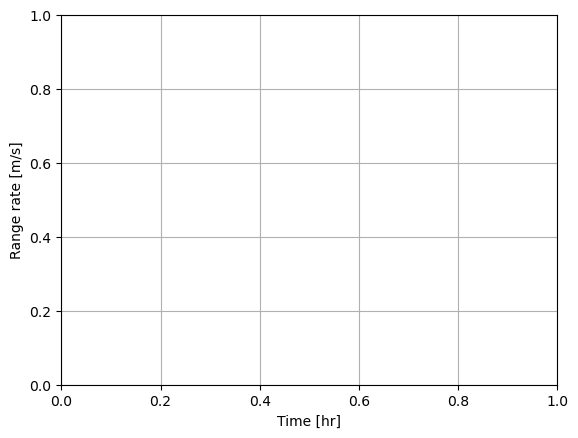

In [117]:
plt.xlabel("Time [hr]")
plt.ylabel("Range rate [m/s]")
plt.grid()

In [118]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### Residuals history
One might also opt to instead plot the **behaviour of the residuals** per iteration of the estimator. To this end, we have thus plotted the residuals of the individual observations as a function of time. Note that we can observe a seemingly equal spread around zero. As expected - since we have not defined it this way - the observation is thus not biased.

In [119]:
residual_history = estimation_output.residual_history

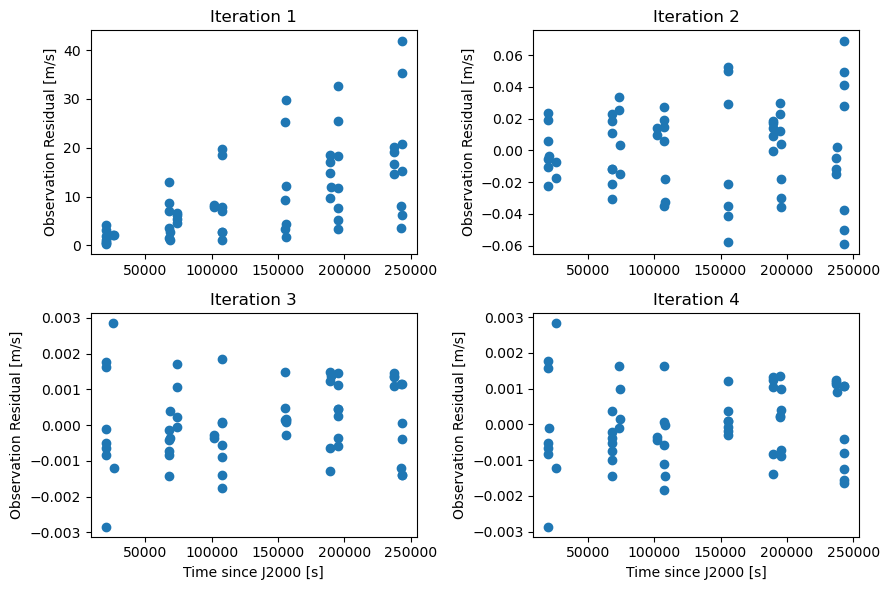

In [120]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 6))
subplots_list = [ax1, ax2, ax3, ax4]
for i in range(4):
    subplots_list[i].scatter(observation_times, residual_history[:, i])
    subplots_list[i].set_ylabel("Observation Residual [m/s]")
    subplots_list[i].set_title("Iteration "+str(i+1))

ax3.set_xlabel("Time since J2000 [s]")
ax4.set_xlabel("Time since J2000 [s]")
plt.tight_layout()
plt.show()

### Final residuals
Finally, one can plot the **statistical distribution of the final residuals** between the simulated observations and the estimated orbit. Ideally, given the type of observable we have used (i.e. free of any bias) as well as a statistically sufficient high number of observations, we would expect to see a Gaussian distribution with zero mean here.

In [121]:
final_residuals = estimation_output.final_residuals

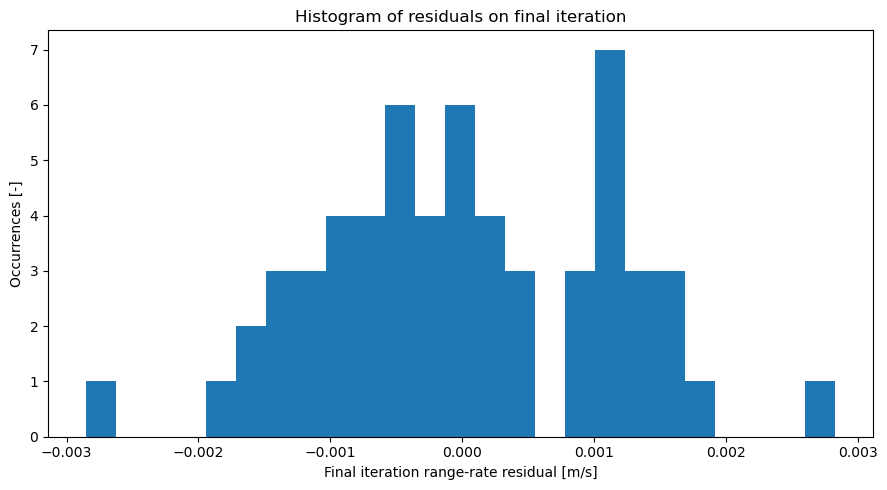

In [125]:
plt.figure(figsize=(9,5))
plt.hist(final_residuals, 25)
plt.xlabel('Final iteration range-rate residual [m/s]')
plt.ylabel('Occurrences [-]')
plt.title('Histogram of residuals on final iteration')
plt.tight_layout()
plt.show()
plt.show()